# Hannum Clock with FHE (Concrete-ML & Concrete Numpy)

This notebook implements the Hannum epigenetic age estimator over Fully Homomorphic Encryption using Concrete ML and Concrete Numpy.

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import time
import gzip
import polars as pl
import matplotlib.pyplot as plt
from concrete.ml.sklearn import LinearRegression
from concrete.ml.deployment import FHEModelDev, FHEModelClient, FHEModelServer
from concrete import fhe


## Functions

In [10]:
def load_hannum_coefficients(path, sheet_name=0, intercept=-0.069):

    df = pd.read_excel(path, sheet_name=sheet_name)
    coefs_df = df.set_index("Marker")[["Coefficient"]]

    print(f"Loaded {len(coefs_df)} CpGs and intercept = {intercept:.4f}")
    return coefs_df, intercept


def load_betas_aligned(file_path, coefs_df, n_samples=100, impute_value=0.5):

    target_cpgs = coefs_df.index.tolist()

    # Load header to get sample names
    with open(file_path, "rt") as f:
        header = f.readline().strip().split('\t')

    id_col = header[0]
    sample_cols = [col for col in header[1:] if "Detection Pval" not in col][:n_samples]
    usecols = [id_col] + sample_cols

    # Read only relevant columns
    df_pl = pl.read_csv(
        file_path,
        separator='\t',
        has_header=True,
        columns=usecols,
        null_values=["NA"]
    )

    # Filter to CpGs available in the file
    df_filtered = df_pl.filter(pl.col(id_col).is_in(target_cpgs)).to_pandas().set_index(id_col)

    # Ensure correct order and impute missing CpGs
    aligned_betas = df_filtered.reindex(coefs_df.index)
    aligned_betas = aligned_betas.fillna(impute_value)

    print(f"Loaded and aligned beta matrix: {aligned_betas.shape[0]} CpGs × {aligned_betas.shape[1]} samples")
    return aligned_betas


def predict_epigenetic_age(betas, coefs_df, intercept):

    common = coefs_df.index.intersection(betas.index)
    coefs = coefs_df.loc[common, "Coefficient"]
    betas = betas.loc[common]
    return betas.T.dot(coefs) + intercept
    

## Load Hannum coefficients and Beta values

In [4]:
# Define file paths
hannum_coef_file = os.path.expanduser("~/data/hannum_coefs.xlsx")
betas_file = os.path.expanduser("~/data/GSE40279_average_beta.txt")


In [5]:
coefs_df, intercept = load_hannum_coefficients(hannum_coef_file, )
aligned_betas = load_betas_aligned(betas_file, coefs_df)


Loaded 71 CpGs and intercept = -0.0690
Loaded and aligned beta matrix: 71 CpGs × 100 samples


## Train and Compile Linear Regression Model with FHE

In [6]:
scaling_factor = 1000

# X_original: raw beta values (float32, not scaled)
X_original = aligned_betas.T.values.astype(np.float32)

# X_scaled: only for the FHE model
X_scaled = X_original * scaling_factor

# Target in real units (years)
y_train = X_original @ coefs_df["Coefficient"].values + intercept

# Fit FHE model using scaled input, but y in real units (years)
model = LinearRegression(n_bits=10)
model.fit(X_scaled, y_train)
model.compile(X_scaled)

# Export FHE model
fhe_dir = "fhe_hannum_model"
if os.path.exists(fhe_dir):
    shutil.rmtree(fhe_dir)
dev = FHEModelDev(path_dir=fhe_dir, model=model)
dev.save()


## FHE Inference for One Sample

In [8]:
# Init client & server
client = FHEModelClient(path_dir=fhe_dir, key_dir="client_keys/")
serialized_evaluation_keys = client.get_serialized_evaluation_keys()
server = FHEModelServer(path_dir=fhe_dir)
server.load()

# Predict a single sample in cleartext
X_input_clear = X_original[[0]]  # Not scaled
y_clear = X_input_clear @ coefs_df["Coefficient"].values + intercept
print(f"Clear prediction: {y_clear[0]:.4f} years")

# Predict same sample with FHE
X_input_fhe = X_input_clear * scaling_factor
encrypted = client.quantize_encrypt_serialize(X_input_fhe)
out = server.run(encrypted, serialized_evaluation_keys)
fhe_pred = client.deserialize_decrypt_dequantize(out)[0]
print(f"FHE prediction: {fhe_pred:.4f} years")


Clear prediction: 67.0657 years
FHE prediction: 67.0910 years


## FHE Inference for Multiple Samples

In [9]:
# Batch predictions
fhe_preds = []
for i in range(20):
    x_clear = X_original[[i]]  # Unscaled for manual prediction
    x_fhe = x_clear * scaling_factor  # Scaled for FHE

    y_clear = x_clear @ coefs_df["Coefficient"].values + intercept

    enc = client.quantize_encrypt_serialize(x_fhe)
    out = server.run(enc, serialized_evaluation_keys)
    y_fhe = client.deserialize_decrypt_dequantize(out)[0]

    print(f"Sample {i+1:02d} — Clear: {y_clear[0]:.2f} years, FHE: {y_fhe:.2f} years")
    fhe_preds.append(y_fhe)


Sample 01 — Clear: 67.07 years, FHE: 67.09 years
Sample 02 — Clear: 86.10 years, FHE: 86.05 years
Sample 03 — Clear: 68.88 years, FHE: 68.81 years
Sample 04 — Clear: 68.83 years, FHE: 68.79 years
Sample 05 — Clear: 67.86 years, FHE: 67.83 years
Sample 06 — Clear: 84.16 years, FHE: 84.15 years
Sample 07 — Clear: 77.69 years, FHE: 77.71 years
Sample 08 — Clear: 76.53 years, FHE: 76.50 years
Sample 09 — Clear: 79.83 years, FHE: 79.82 years
Sample 10 — Clear: 82.35 years, FHE: 82.28 years
Sample 11 — Clear: 87.14 years, FHE: 87.14 years
Sample 12 — Clear: 57.66 years, FHE: 57.64 years
Sample 13 — Clear: 81.41 years, FHE: 81.36 years
Sample 14 — Clear: 51.93 years, FHE: 51.87 years
Sample 15 — Clear: 73.30 years, FHE: 73.32 years
Sample 16 — Clear: 73.95 years, FHE: 73.94 years
Sample 17 — Clear: 73.04 years, FHE: 72.99 years
Sample 18 — Clear: 81.80 years, FHE: 81.74 years
Sample 19 — Clear: 89.70 years, FHE: 89.62 years
Sample 20 — Clear: 61.84 years, FHE: 61.82 years


## Evaluation on GSE55763: Encrypted Epigenetic Age Prediction vs Chronological Age

### Functions

In [11]:
def load_chronological_ages_gse55763(file_path):

    file_path = os.path.expanduser(file_path)
    open_func = gzip.open if file_path.endswith(".gz") else open

    sample_ids = []
    ages = []

    with open_func(file_path, "rt") as f:
        for line in f:
            if line.startswith("!Sample_title"):
                sample_ids = [
                    s.split(",")[-1].strip().replace('"', '') 
                    for s in line.strip().split('\t')[1:]
                ]
            elif "characteristics_ch1" in line.lower() and "age" in line.lower():
                ages = [
                    float(s.split(":")[-1].strip().replace('"', '')) 
                    for s in line.strip().split('\t')[1:]
                ]

    if not sample_ids or not ages:
        raise ValueError("Could not extract sample IDs or ages from the file.")

    df = pd.DataFrame({"Sample_ID": sample_ids, "Chronological_Age": ages}).set_index("Sample_ID")
    print(f"Parsed {len(df)} ages from GSE55763 metadata.")
    return df


def compare_ages(epigenetic_ages, chronological_df, plot=True):

    # Join the two sources by sample ID
    combined = chronological_df.join(epigenetic_ages.rename("Epigenetic_Age"))
    combined = combined.dropna()

    print(f"Comparison table created with {combined.shape[0]} matching samples.")

    if plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(combined["Chronological_Age"], combined["Epigenetic_Age"], alpha=0.7)
        plt.plot([0, 100], [0, 100], 'r--', label="Ideal match")
        plt.xlabel("Chronological Age")
        plt.ylabel("Epigenetic Age")
        plt.title("Epigenetic vs Chronological Age")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return combined

### Load Hannum coefficicients, Beta values and Chronological age metadata

In [12]:
hannum_coef_file = os.path.expanduser("~/data/hannum_coefs.xlsx")
betas_file = os.path.expanduser("~/data/GSE55763_normalized_betas.txt")
sample_metadata_file = os.path.expanduser("~/data/GSE55763_series_matrix.txt.gz")

In [13]:
coefs_df, intercept = load_hannum_coefficients(hannum_coef_file, sheet_name=0)
aligned_betas = load_betas_aligned(betas_file, coefs_df, n_samples=100)
ages_df = load_chronological_ages_gse55763(sample_metadata_file)

Loaded 71 CpGs and intercept = -0.0690
Loaded and aligned beta matrix: 71 CpGs × 100 samples
Parsed 2711 ages from GSE55763 metadata.


### FHE Inference and Comparison with chronological ages

In [14]:
scaling_factor = 1000

# Prepare data
X_original = aligned_betas.T.values.astype(np.float32) 
X_scaled = X_original * scaling_factor                
y_train = X_original @ coefs_df["Coefficient"].values + intercept  

# Train and compile Concrete-ML model on new data
model = LinearRegression(n_bits=10)
model.fit(X_scaled, y_train)
model.compile(X_scaled)


Sample 00 — Chron: 37.00 years, Clear: 48.09 years, FHE: 48.05 years
Sample 01 — Chron: 43.80 years, Clear: 52.39 years, FHE: 52.37 years
Sample 02 — Chron: 47.40 years, Clear: 56.39 years, FHE: 56.38 years
Sample 03 — Chron: 38.60 years, Clear: 47.64 years, FHE: 47.59 years
Sample 04 — Chron: 44.30 years, Clear: 50.17 years, FHE: 50.12 years
Sample 05 — Chron: 50.40 years, Clear: 63.59 years, FHE: 63.53 years
Sample 06 — Chron: 56.50 years, Clear: 67.18 years, FHE: 67.13 years
Sample 07 — Chron: 66.50 years, Clear: 80.96 years, FHE: 80.94 years
Sample 08 — Chron: 35.70 years, Clear: 42.45 years, FHE: 42.40 years
Sample 09 — Chron: 44.00 years, Clear: 56.03 years, FHE: 55.99 years
Sample 10 — Chron: 51.10 years, Clear: 57.71 years, FHE: 57.64 years
Sample 11 — Chron: 43.30 years, Clear: 51.05 years, FHE: 51.02 years
Sample 12 — Chron: 55.50 years, Clear: 67.71 years, FHE: 67.66 years
Sample 13 — Chron: 68.50 years, Clear: 74.20 years, FHE: 74.21 years
Sample 14 — Chron: 37.00 years, Cl

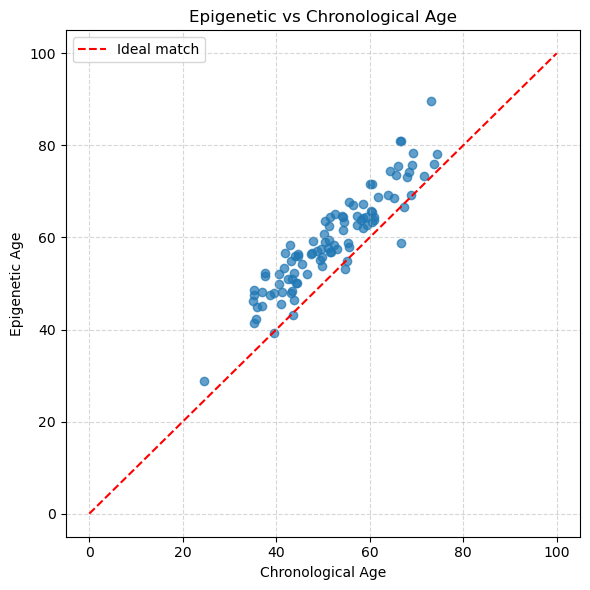

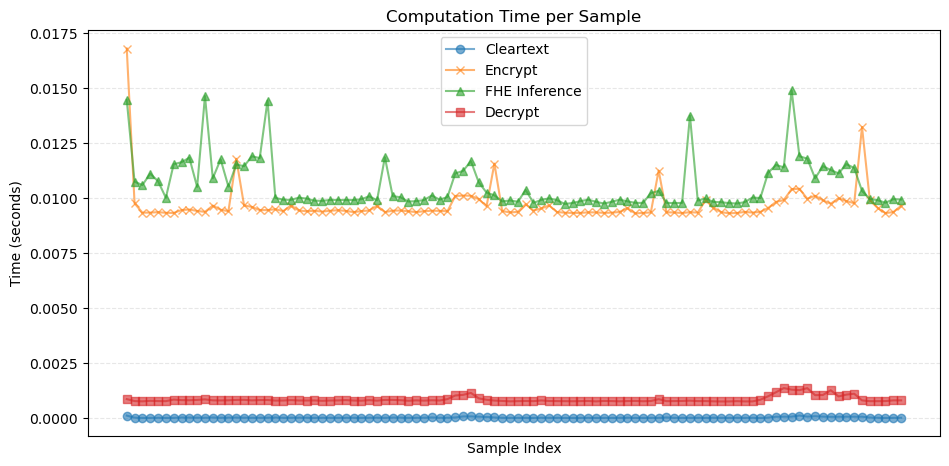

In [15]:
fhe_dir = "fhe_hannum_model"

if os.path.exists(fhe_dir):
    shutil.rmtree(fhe_dir)

FHEModelDev(path_dir=fhe_dir, model=model).save()
client = FHEModelClient(path_dir=fhe_dir, key_dir="client_keys/")
serialized_evaluation_keys = client.get_serialized_evaluation_keys()
server = FHEModelServer(path_dir=fhe_dir)
server.load()

# Run batch inference and track timings
sample_ids = aligned_betas.columns
fhe_preds = []
clear_preds = []
timings = []

for i, sample_id in enumerate(sample_ids):
    x_clear = X_original[i].reshape(1, -1)
    x_fhe = x_clear * scaling_factor

    # Cleartext prediction (manual)
    start_clear = time.time()
    clear_pred = (x_clear @ coefs_df["Coefficient"].values + intercept).item()
    clear_time = time.time() - start_clear
    clear_preds.append(clear_pred)

    # FHE prediction
    start_enc = time.time()
    encrypted = client.quantize_encrypt_serialize(x_fhe)
    enc_time = time.time() - start_enc

    start_fhe = time.time()
    encrypted_result = server.run(encrypted, serialized_evaluation_keys)
    fhe_time = time.time() - start_fhe

    start_dec = time.time()
    decrypted = client.deserialize_decrypt_dequantize(encrypted_result)
    fhe_pred = decrypted[0]  # Already in years, no scaling needed
    dec_time = time.time() - start_dec
    fhe_preds.append(fhe_pred)

    # Log timings
    chron_age = ages_df.loc[sample_id, "Chronological_Age"]
    timings.append({
        "Sample": sample_id,
        "Cleartext (s)": clear_time,
        "Encrypt (s)": enc_time,
        "FHE Inference (s)": fhe_time,
        "Decrypt (s)": dec_time,
        "FHE Total (s)": enc_time + fhe_time + dec_time
    })

    print(f"Sample {i:02d} — Chron: {chron_age:.2f} years, Clear: {clear_pred:.2f} years, FHE: {fhe_pred:.2f} years")

# Build timing report
timing_df = pd.DataFrame(timings).set_index("Sample")

summary = {
    step: (timing_df[step].mean(), timing_df[step].std())
    for step in ["Cleartext (s)", "Encrypt (s)", "FHE Inference (s)", "Decrypt (s)"]
}

print("\nStep\t\t\tAverage Time (s) ± Std")
for step, (avg, std) in summary.items():
    print(f"{step:<20} {avg:.4f} ± {std:.4f}")

# Evaluate predictions
fhe_series = pd.Series(fhe_preds, index=sample_ids, name="Epigenetic_Age (years)")
ages_subset = ages_df.loc[sample_ids]
comparison_df = compare_ages(fhe_series, ages_subset, plot=True)

# Plot computation time
plt.figure(figsize=(10, 5))
plt.plot(timing_df["Cleartext (s)"], label="Cleartext", marker="o", alpha=0.6)
plt.plot(timing_df["Encrypt (s)"], label="Encrypt", marker="x", alpha=0.6)
plt.plot(timing_df["FHE Inference (s)"], label="FHE Inference", marker="^", alpha=0.6)
plt.plot(timing_df["Decrypt (s)"], label="Decrypt", marker="s", alpha=0.6)
plt.title("Computation Time per Sample")
plt.xlabel("Sample Index")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.xticks([])
plt.show()


## Precision vs. Bitwidth: Choosing Optimal n_bits

In [16]:
bit_results = []
N = 20  # Number of samples to evaluate

# Subset for evaluation
X_eval_clear = X_original[:N]                                           # Unscaled input
X_eval_fhe = X_eval_clear * scaling_factor                              # Scaled input for FHE
true_preds = X_eval_clear @ coefs_df["Coefficient"].values + intercept  # Ground truth in years

for n in [16, 14, 12, 10, 8, 6, 4]:
    print(f"\nEvaluating n_bits = {n}")

    X_train_full = X_original  # (100, n_features)
    y_train_full = X_train_full @ coefs_df["Coefficient"].values + intercept
    
    # Train and compile model using scaled input, but target in years
    model_n = LinearRegression(n_bits=n)
    model_n.fit(X_train_full * scaling_factor, y_train_full)
    model_n.compile(X_scaled)

    # Export and set up client/server
    fhe_dir = f"fhe_hannum_model_n{n}"
    if os.path.exists(fhe_dir):
        shutil.rmtree(fhe_dir)
    FHEModelDev(path_dir=fhe_dir, model=model_n).save()

    client = FHEModelClient(path_dir=fhe_dir, key_dir="client_keys/")
    server = FHEModelServer(path_dir=fhe_dir)
    server.load()
    serialized_keys = client.get_serialized_evaluation_keys()

    abs_errors, preds_fhe = [], []
    total_time = 0.0

    for i, x_fhe in enumerate(X_eval_fhe):
        x_reshaped = x_fhe.reshape(1, -1)

        start = time.time()
        enc = client.quantize_encrypt_serialize(x_reshaped)
        out_enc = server.run(enc, serialized_keys)
        fhe_pred = client.deserialize_decrypt_dequantize(out_enc)[0]  # Already in years
        elapsed = time.time() - start

        total_time += elapsed
        preds_fhe.append(fhe_pred)
        abs_errors.append(abs(fhe_pred - true_preds[i]))

    bit_results.append({
        "n_bits": n,
        "mean_error (years)": np.mean(abs_errors),
        "max_error (years)": np.max(abs_errors),
        "min_pred (years)": np.min(preds_fhe),
        "max_pred (years)": np.max(preds_fhe),
        "mean_pred (years)": np.mean(preds_fhe),
        "total_time (s)": total_time,
        "avg_time_per_sample (s)": total_time / N
    })

    print(f"→ Mean error: {np.mean(abs_errors):.4f} years")
    print(f"→ Max error: {np.max(abs_errors):.4f} years")
    print(f"→ Pred. range: {np.min(preds_fhe):.2f} – {np.max(preds_fhe):.2f} years")
    print(f"→ Avg. time/sample: {total_time / N:.4f} seconds")



Evaluating n_bits = 16
→ Mean error: 0.0003 years
→ Max error: 0.0009 years
→ Pred. range: 42.45 – 80.96 years
→ Avg. time/sample: 0.0292 seconds

Evaluating n_bits = 14
→ Mean error: 0.0012 years
→ Max error: 0.0025 years
→ Pred. range: 42.45 – 80.96 years
→ Avg. time/sample: 0.0266 seconds

Evaluating n_bits = 12
→ Mean error: 0.0062 years
→ Max error: 0.0136 years
→ Pred. range: 42.45 – 80.95 years
→ Avg. time/sample: 0.0236 seconds

Evaluating n_bits = 10
→ Mean error: 0.0367 years
→ Max error: 0.0688 years
→ Pred. range: 42.40 – 80.94 years
→ Avg. time/sample: 0.0219 seconds

Evaluating n_bits = 8
→ Mean error: 0.3957 years
→ Max error: 0.5572 years
→ Pred. range: 42.26 – 80.61 years
→ Avg. time/sample: 0.0185 seconds

Evaluating n_bits = 6
→ Mean error: 0.7082 years
→ Max error: 1.4397 years
→ Pred. range: 41.13 – 79.92 years
→ Avg. time/sample: 0.0160 seconds

Evaluating n_bits = 4
→ Mean error: 3.6195 years
→ Max error: 9.0935 years
→ Pred. range: 36.06 – 78.16 years
→ Avg. ti

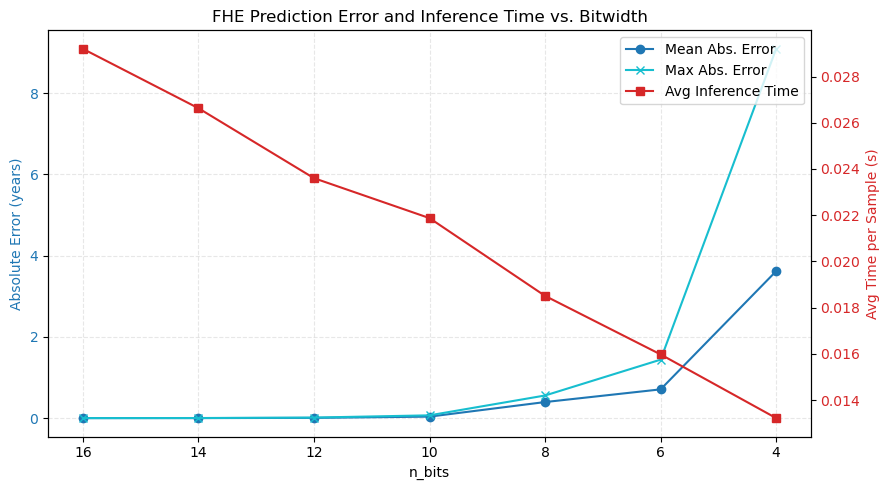

In [17]:
df_bit_results = pd.DataFrame(bit_results)

fig, ax1 = plt.subplots(figsize=(9, 5))

# Plot errors on the left y-axis
ax1.plot(df_bit_results["n_bits"], df_bit_results["mean_error (years)"], marker="o", label="Mean Abs. Error", color="tab:blue")
ax1.plot(df_bit_results["n_bits"], df_bit_results["max_error (years)"], marker="x", label="Max Abs. Error", color="tab:cyan")
ax1.set_xlabel("n_bits")
ax1.set_ylabel("Absolute Error (years)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.invert_xaxis()
ax1.grid(True, linestyle="--", alpha=0.3)

# Create a second y-axis for inference time
ax2 = ax1.twinx()
ax2.plot(df_bit_results["n_bits"], df_bit_results["avg_time_per_sample (s)"], marker="s", label="Avg Inference Time", color="tab:red")
ax2.set_ylabel("Avg Time per Sample (s)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title and layout
plt.title("FHE Prediction Error and Inference Time vs. Bitwidth")
fig.tight_layout()

# Custom legend combining both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.show()


## Comparison between Concrete ML and Concrete-Numpy Inference

In [18]:
# Parameters
N = 20  # Number of samples to evaluate

# Input data
X_float = aligned_betas.T.values[:N]  # Unscaled CpG beta values
X_scaled = (X_float * scaling_factor).astype(int)  # Scaled integer inputs for FHE

# ======= Concrete-ML parameters (from trained model) =======
weights_cml = (model.sklearn_model.coef_ * scaling_factor).astype(int)
bias_cml = int(model.sklearn_model.intercept_)  # Already scaled for output in years

# ========= Plaintext prediction (years) =========
start_plain = time.time()
y_plain = X_float @ coefs_df["Coefficient"].values + intercept
time_plain = time.time() - start_plain  

# ========= Concrete ML encrypted inference (returns age in years) =========
client = FHEModelClient(path_dir="fhe_hannum_model_n10", key_dir="client_keys/")
server = FHEModelServer(path_dir="fhe_hannum_model_n10")
server.load()
keys = serialized_evaluation_keys  # already generated

y_cml = []
t_cml = []

for x in X_scaled:
    x = x.reshape(1, -1)
    start = time.time()
    enc = client.quantize_encrypt_serialize(x)
    out = server.run(enc, keys)
    dec = client.deserialize_decrypt_dequantize(out)[0]  # Already in years
    y_cml.append(dec)
    t_cml.append(time.time() - start)

# ========= Concrete-Numpy encrypted inference (raw scaled output) =========

weights_cnp = (coefs_df["Coefficient"].values * scaling_factor).astype(int)
bias_cnp = int(intercept * (scaling_factor ** 2))  # Scaled intercept

@fhe.compiler({"x": "encrypted"})
def fhe_manual(x):
    return np.dot(x, weights_cnp) + bias_cnp  # Raw scaled output

circuit = fhe_manual.compile([X_scaled[0].flatten()])

y_cnp = []
t_cnp = []

for x in X_scaled:
    x_flat = x.flatten()
    start = time.time()
    enc = circuit.encrypt(x_flat)
    out = circuit.run(enc)
    dec = circuit.decrypt(out) / (scaling_factor ** 2)  # Convert back to years
    y_cnp.append(dec)
    t_cnp.append(time.time() - start)

# ======= Results summary =======
df = pd.DataFrame({
    "Sample": [f"Sample_{i+1}" for i in range(N)],
    "Plaintext (years)": y_plain[:N],
    "FHE_ConcreteML (years)": y_cml,
    "FHE_ConcreteNumpy (years)": y_cnp,
    "Time_Plaintext (s)": [time_plain / N] * N,
    "Time_CML (s)": t_cml,
    "Time_CNP (s)": t_cnp,
    "AbsErr_CML (years)": np.abs(np.array(y_cml) - y_plain[:N]),
    "AbsErr_CNP (years)": np.abs(np.array(y_cnp) - y_plain[:N]),
})

# Summary metrics
mean_abs_cml = df["AbsErr_CML (years)"].mean()
max_abs_cml = df["AbsErr_CML (years)"].max()
mean_abs_cnp = df["AbsErr_CNP (years)"].mean()
max_abs_cnp = df["AbsErr_CNP (years)"].max()

print(f"Inference Comparison Summary with {N} samples")
print("-" * 50)
print(f"Mean Absolute Error (Concrete ML):     {mean_abs_cml:.4f} years")
print(f"Max Absolute Error  (Concrete ML):     {max_abs_cml:.4f} years")
print(f"Mean Absolute Error (Concrete-Numpy):  {mean_abs_cnp:.4f} years")
print(f"Max Absolute Error  (Concrete-Numpy):  {max_abs_cnp:.4f} years")
print("-" * 50)
print(f"Avg Time/sample (Plaintext):           {time_plain / N:.6f} seconds")
print(f"Avg Time/sample (Concrete ML FHE):     {np.mean(t_cml):.6f} seconds")
print(f"Avg Time/sample (Concrete-Numpy FHE):  {np.mean(t_cnp):.6f} seconds")


Inference Comparison Summary with 20 samples
--------------------------------------------------
Mean Absolute Error (Concrete ML):     0.1102 years
Max Absolute Error  (Concrete ML):     0.1702 years
Mean Absolute Error (Concrete-Numpy):  0.0771 years
Max Absolute Error  (Concrete-Numpy):  0.1264 years
--------------------------------------------------
Avg Time/sample (Plaintext):           0.000008 seconds
Avg Time/sample (Concrete ML FHE):     0.021442 seconds
Avg Time/sample (Concrete-Numpy FHE):  0.015031 seconds
